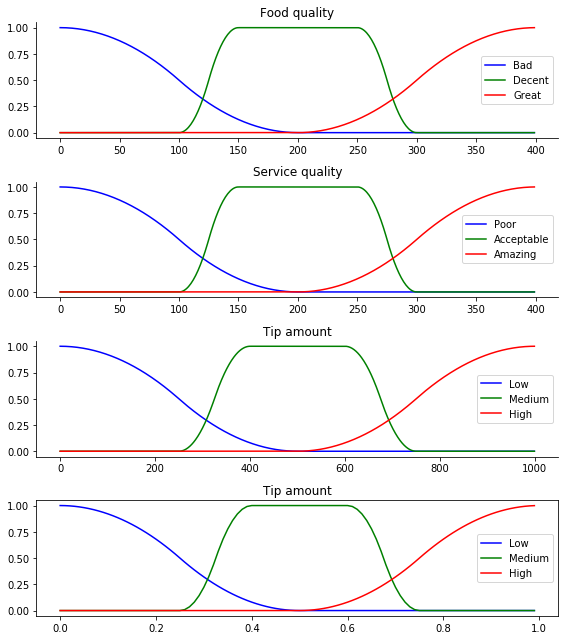

In [47]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# Generate universe variables
#   * Quality and service on subjective ranges [0, 10]
#   * Tip has a range of [0, 25] in units of percentage points
x_MSD = np.arange(0, 400, 1)
x_autonomy = np.arange(0, 400, 1)
x_time = np.arange(0, 1000, 1)
x_method = np.arange(0, 1, 0.01)

# Generate fuzzy membership functions
MSD_lo = fuzz.zmf(x_MSD, 0, 200)
MSD_md = fuzz.pimf(x_MSD, 100, 150, 250, 300)
MSD_hi = fuzz.smf(x_MSD, 200, 400)
autonomy_lo = fuzz.zmf(x_autonomy, 0, 200)
autonomy_md = fuzz.pimf(x_autonomy, 100, 150, 250, 300)
autonomy_hi = fuzz.smf(x_autonomy, 200, 400)
time_lo = fuzz.zmf(x_time, 0, 500)
time_md = fuzz.pimf(x_time, 250, 400, 600, 750)
time_hi = fuzz.smf(x_time, 500, 1000)
method_lo = fuzz.zmf(x_method, 0, 0.5)
method_md = fuzz.pimf(x_method, 0.25, 0.4, 0.6, 0.75)
method_hi = fuzz.smf(x_method, 0.5, 1)

# Visualize these universes and membership functions
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, figsize=(8, 9))

ax0.plot(x_MSD, MSD_lo, 'b', linewidth=1.5, label='Bad')
ax0.plot(x_MSD, MSD_md, 'g', linewidth=1.5, label='Decent')
ax0.plot(x_MSD, MSD_hi, 'r', linewidth=1.5, label='Great')
ax0.set_title('Food quality')
ax0.legend()

ax1.plot(x_autonomy, autonomy_lo, 'b', linewidth=1.5, label='Poor')
ax1.plot(x_autonomy, autonomy_md, 'g', linewidth=1.5, label='Acceptable')
ax1.plot(x_autonomy, autonomy_hi, 'r', linewidth=1.5, label='Amazing')
ax1.set_title('Service quality')
ax1.legend()

ax2.plot(x_time, time_lo, 'b', linewidth=1.5, label='Low')
ax2.plot(x_time, time_md, 'g', linewidth=1.5, label='Medium')
ax2.plot(x_time, time_hi, 'r', linewidth=1.5, label='High')
ax2.set_title('Tip amount')
ax2.legend()

ax3.plot(x_method, method_lo, 'b', linewidth=1.5, label='Low')
ax3.plot(x_method, method_md, 'g', linewidth=1.5, label='Medium')
ax3.plot(x_method, method_hi, 'r', linewidth=1.5, label='High')
ax3.set_title('Tip amount')
ax3.legend()
# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

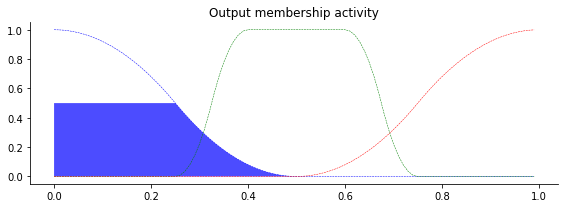

In [55]:
# We need the activation of our fuzzy membership functions at these values.
# The exact values 6.5 and 9.8 do not exist on our universes...
# This is what fuzz.interp_membership exists for!
autonomy = 100
MSD = 50
time = 800

MSD_level_lo = fuzz.interp_membership(x_MSD, MSD_lo, MSD)
MSD_level_md = fuzz.interp_membership(x_MSD, MSD_md, MSD)
MSD_level_hi = fuzz.interp_membership(x_MSD, MSD_hi, MSD)

autonomy_level_lo = fuzz.interp_membership(x_autonomy, autonomy_lo, autonomy)
autonomy_level_md = fuzz.interp_membership(x_autonomy, autonomy_md, autonomy)
autonomy_level_hi = fuzz.interp_membership(x_autonomy, autonomy_hi, autonomy)

time_level_lo = fuzz.interp_membership(x_time, time_lo, time)
time_level_md = fuzz.interp_membership(x_time, time_md, time)
time_level_hi = fuzz.interp_membership(x_time, time_hi, time)

# Rules
active_rule11 = np.fmin(MSD_level_lo, autonomy_level_lo)
active_rule12 = np.fmax(np.fmin(time_level_lo, autonomy_level_lo), active_rule11)
method_activation_lo = np.fmin(active_rule12, method_lo)

active_rule21 = np.fmin(MSD_level_md, autonomy_level_md)
active_rule22 = np.fmax(np.fmin(time_level_md, autonomy_level_md), active_rule21)
method_activation_md = np.fmin(active_rule22, method_md)

active_rule31 = np.fmin(MSD_level_hi, autonomy_level_hi)
active_rule32 = np.fmax(np.fmin(time_level_hi, autonomy_level_hi), active_rule31)
method_activation_hi = np.fmin(active_rule32, method_hi)

method0 = np.zeros_like(x_method)

# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.fill_between(x_method, method0, method_activation_lo, facecolor='b', alpha=0.7)
ax0.plot(x_method, method_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.fill_between(x_method, method0, method_activation_md, facecolor='g', alpha=0.7)
ax0.plot(x_method, method_md, 'g', linewidth=0.5, linestyle='--')
ax0.fill_between(x_method, method0, method_activation_hi, facecolor='r', alpha=0.7)
ax0.plot(x_method, method_hi, 'r', linewidth=0.5, linestyle='--')
ax0.set_title('Output membership activity')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

0.1719156168766247
0.5
[0.17191562]
lo


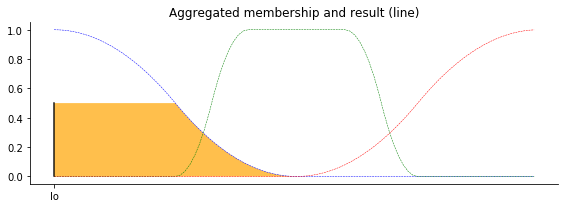

In [67]:
# Aggregate all three output membership functions together
aggregated = np.fmax(method_activation_lo,
                     np.fmax(method_activation_md, method_activation_hi))

# Calculate defuzzified result
method = fuzz.defuzz(x_method, aggregated, 'centroid')
method_activation = fuzz.interp_membership(x_method, aggregated, method)  # for plot

print(method)
print(method_activation)

method1  = np.arange(method, method+1, 1)
print(method1)
method_lo1 = fuzz.zmf(method1, 0, 0.5)
method_md1 = fuzz.pimf(method1, 0.25, 0.4, 0.6, 0.75)
method_hi1 = fuzz.smf(method1, 0.5, 1)

import operator
stats = {'lo':method_lo1[0], 'md':method_md1[0], 'hi': method_hi1[0]}
method = max(stats.items(), key=operator.itemgetter(1))[0]
print(method)

# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.plot(x_method, method_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.plot(x_method, method_md, 'g', linewidth=0.5, linestyle='--')
ax0.plot(x_method, method_hi, 'r', linewidth=0.5, linestyle='--')
ax0.fill_between(x_method, method0, aggregated, facecolor='Orange', alpha=0.7)
ax0.plot([method, method], [0, method_activation], 'k', linewidth=1.5, alpha=0.9)
ax0.set_title('Aggregated membership and result (line)')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()